# 생물정보학 및 실습 1 - Final Project

생물정보학
2022-38072
장성은

```
생물정보학 및 실습 1
서울대학교 생물정보학전공/생명과학부 2024년 1학기

이 노트북은 Creative Commons BY-SA 조건으로 재사용 가능합니다.
장혜식 <hyeshik@snu.ac.kr>, 서울대학교 생명과학부
```



## Figure S3C 재현하기

Transcriptome에서 error가 많이 나오는 부분들 주변 서열을 모아서 문맥을 파악합니다.


To better understand LIN28A-RNA interactions, we further
analyzed patterns around the potential LIN28A binding sites
(Figures 2A and S3C). The frequently mutated G is preceded
by two bases with strong preference for A or U and is followed
by three bases favoring G or A.

Consensus of confident binding sites from individual CLIP-seq libraries

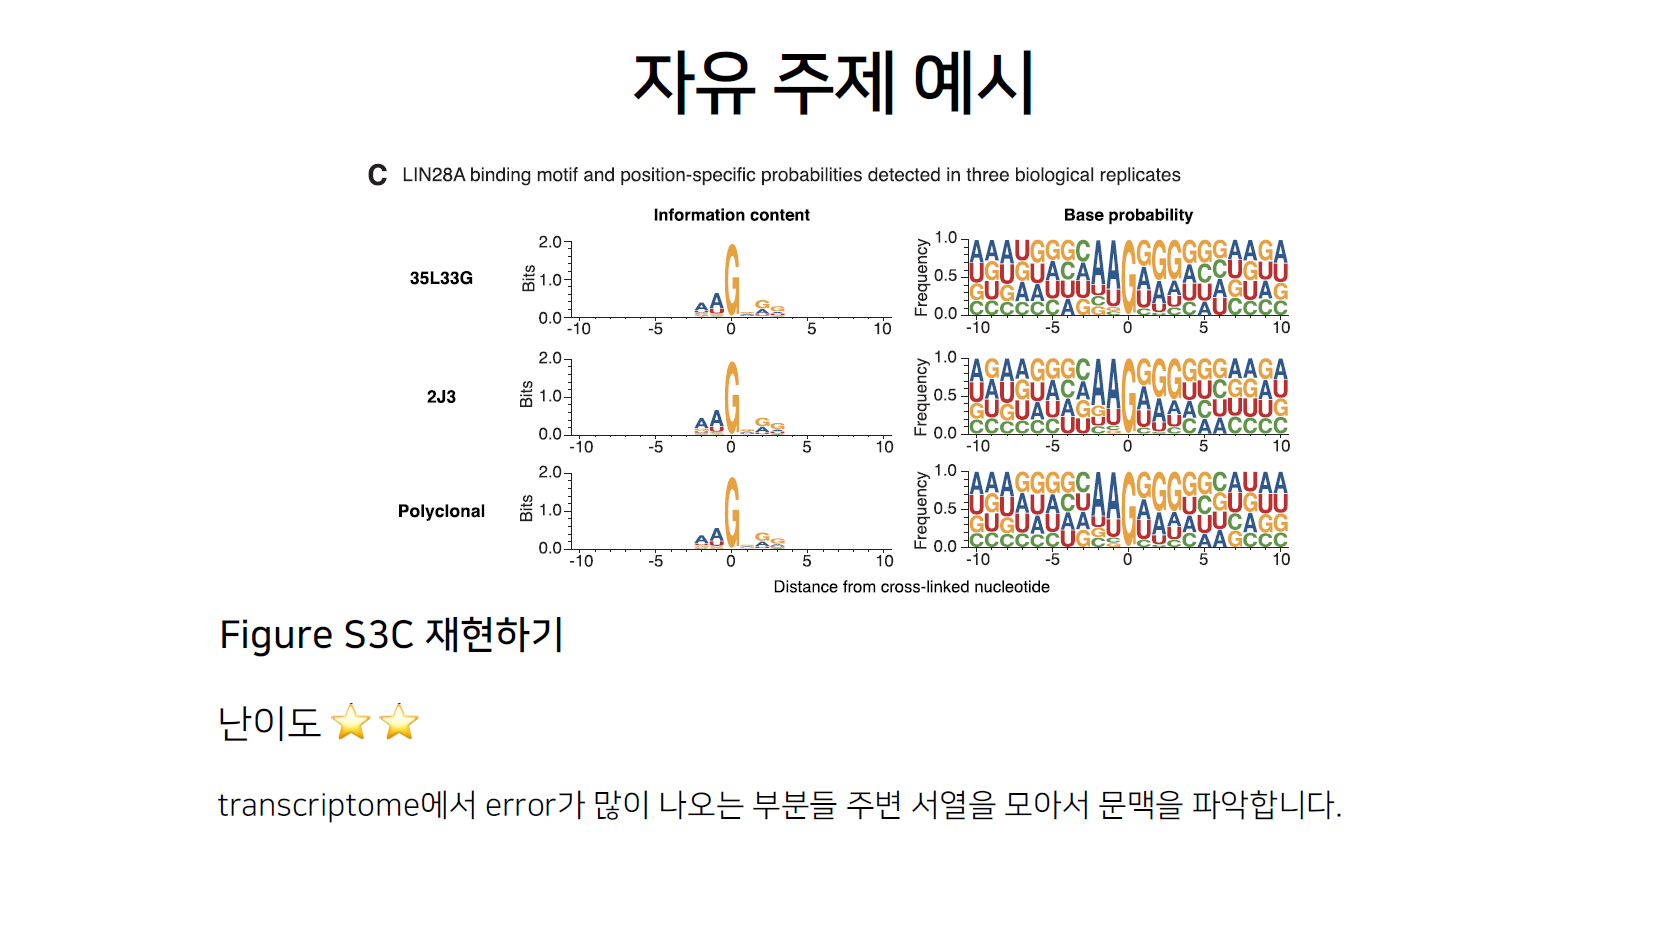

In [26]:
!ls

 CLIP-35L33G.bam				 'Project topic.png'
'CoLab_FinalProj_2024(2022-38072) copy 2.ipynb'   version_1
 mm9.fa						  version_2
 mm9.fa.fai					  version_3
 output_sequences.fa				  version_4


In [27]:
import math
import pysam
import logomaker
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from weblogo import LogoData, LogoOptions, LogoFormat, png_formatter

In [28]:
# read file

bam_file_path = "CLIP-35L33G.bam"
bamfile = pysam.AlignmentFile(bam_file_path, "rb")

In [29]:
# check file
for i, read in enumerate(bamfile):
    if i <= 5:
        print(read)
    else: break

SRR458758.23028115	0	#0	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	array('B', [39, 39, 38, 39, 39, 38, 36, 31, 38, 38, 39, 39, 36, 35, 30, 38, 36, 38, 35, 38])	[('MD', '20'), ('NH', 40), ('HI', 1), ('NM', 0), ('SM', 0), ('XQ', 40), ('X2', 40), ('XO', 'UM'), ('XS', '-')]
SRR458758.23879202	0	#0	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	array('B', [38, 33, 38, 38, 36, 36, 32, 32, 37, 28, 34, 36, 36, 35, 36, 38, 33, 38, 38, 29])	[('MD', '20'), ('NH', 40), ('HI', 1), ('NM', 0), ('SM', 0), ('XQ', 40), ('X2', 40), ('XO', 'UM'), ('XS', '-')]
SRR458758.23893532	0	#0	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	array('B', [38, 31, 30, 38, 38, 36, 28, 36, 37, 33, 35, 35, 38, 38, 38, 38, 35, 31, 38, 38])	[('MD', '20'), ('NH', 40), ('HI', 1), ('NM', 0), ('SM', 0), ('XQ', 40), ('X2', 40), ('XO', 'UM'), ('XS', '-')]
SRR458758.26501547	0	#0	3056473	0	20M	*	0	0	GAATGGAAGTTCAAGGATCT	array('B', [40, 40, 40, 39, 40, 40, 40, 39, 40, 38, 39, 40, 40, 40, 39, 36, 39, 40, 39, 39])	[('MD', '20'), ('NH', 40), ('HI', 1

In [30]:
# set cut-offs ans base numbers

target_reference_names = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM']

min_length = 25
min_quality = 35

depth_limit = 50
CRES_limit = 0.8

A = 0
T = 1
G = 2
C = 3
DEPTH = 4

In [31]:
# read file

bam_file_path = "CLIP-35L33G.bam"
bamfile = pysam.AlignmentFile(bam_file_path, "rb")

In [32]:
# preprocess with read length and quality score
reads = {}
min_idxs = {}
max_idxs = {}
for bam in bamfile:    
    if bam.reference_name in target_reference_names:
        if bam.reference_name in min_idxs.keys():
            if bam.reference_start < min_idxs[bam.reference_name]: 
                min_idxs[bam.reference_name] = bam.reference_start
        else: 
            min_idxs[bam.reference_name] = bam.reference_start
            
        if bam.reference_name in max_idxs.keys():
            if bam.reference_start + len(bam.query_sequence) > max_idxs[bam.reference_name]: 
                max_idxs[bam.reference_name] = bam.reference_start + len(bam.query_sequence)
        else: 
            max_idxs[bam.reference_name] = bam.reference_start + len(bam.query_sequence)
        
        if bam.reference_name not in reads.keys(): reads[bam.reference_name] = []
        if len(bam.query_sequence) >= min_length and (sum(bam.query_qualities) / len(bam.query_qualities)) >= min_quality:
            reads[bam.reference_name].append(bam)

In [33]:
print(reads.keys())

dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY', 'chrM'])


In [34]:
# get information of each position

position_infos = {}

for reference_name in reads.keys():
    read = reads[reference_name]
    min_idx = min_idxs[reference_name]
    max_idx = max_idxs[reference_name]
    
    position_info = np.zeros((max_idx, 5), dtype=np.uint32)
    for r in read:
        start = r.reference_start
        for idx, base in enumerate(r.query_sequence):
            if base in ['A', 'T', 'G', 'C']:
                position = idx + start
                if position < max_idx:
                    position_info[position, DEPTH] += 1  # depth 증가
                    if base == 'A':
                        position_info[position, A] += 1
                    elif base == 'T':
                        position_info[position, T] += 1
                    elif base == 'G':
                        position_info[position, G] += 1
                    elif base == 'C':
                        position_info[position, C] += 1
    position_infos[reference_name] = position_info
    print(reference_name, position_infos[reference_name].shape[0])

print(len(position_infos))


chr1 195052812
chr2 181652688
chr3 159640712
chr4 156683904
chr5 151638499
chr6 149486964
chr7 144889808
chr8 130024823
chr9 124258672
chr10 130428574


In [ ]:
# save and load positional information

for reference_name in position_infos.keys():
    np.save(f'./CLIP-35L33G_position_info_{reference_name}', position_infos[reference_name])

In [ ]:
# cut-off with depth

binding_sites = {}

for reference_name in position_infos.keys():
    binding_sites[reference_name] = np.flatnonzero(position_infos[reference_name][:, DEPTH] >= depth_limit)
    print(reference_name, binding_sites[reference_name].shape)   

print(len(binding_sites))

chr1 (200563,)
chr2 (145671,)
chr3 (102331,)
chr4 (142243,)
chr5 (118671,)
chr6 (85916,)
chr7 (113133,)
chr8 (91675,)
chr9 (106074,)
chr10 (113659,)
chr11 (176525,)
chr12 (87053,)
chr13 (105122,)
chr14 (66210,)
chr15 (76323,)
chr16 (60393,)
chr17 (80728,)
chr18 (51170,)
chr19 (62148,)
chrX (72226,)
chrY (9686,)
chrM (3460,)
GL456210.1 (0,)
GL456211.1 (0,)
GL456212.1 (0,)
GL456219.1 (0,)
GL456221.1 (0,)
GL456233.2 (0,)
GL456239.1 (0,)
GL456354.1 (0,)
GL456359.1 (0,)
GL456360.1 (0,)
GL456366.1 (0,)
GL456367.1 (0,)
GL456368.1 (55,)
GL456370.1 (30,)
GL456372.1 (0,)
GL456378.1 (24,)
GL456379.1 (0,)
GL456381.1 (0,)
GL456382.1 (261,)
GL456383.1 (0,)
GL456385.1 (0,)
GL456387.1 (0,)
GL456389.1 (0,)
GL456390.1 (0,)
GL456392.1 (0,)
GL456394.1 (0,)
GL456396.1 (0,)
JH584295.1 (0,)
JH584296.1 (0,)
JH584297.1 (0,)
JH584298.1 (0,)
JH584299.1 (0,)
JH584300.1 (0,)
JH584301.1 (0,)
JH584302.1 (0,)
JH584303.1 (0,)
JH584304.1 (29,)
MU069434.1 (36,)
MU069435.1 (609,)
None (74,)
62


In [ ]:
# cut-off with CRES

for reference_name in binding_sites.keys():
    p_As = position_infos[reference_name][binding_sites[reference_name], A] / position_infos[reference_name][binding_sites[reference_name], DEPTH]
    p_Ts = position_infos[reference_name][binding_sites[reference_name], T] / position_infos[reference_name][binding_sites[reference_name], DEPTH]
    p_Gs = position_infos[reference_name][binding_sites[reference_name], G] / position_infos[reference_name][binding_sites[reference_name], DEPTH]
    p_Cs = position_infos[reference_name][binding_sites[reference_name], C] / position_infos[reference_name][binding_sites[reference_name], DEPTH]
    p_bases = np.array([p_As, p_Ts, p_Gs, p_Cs])

    epsilon = 0.00001
    log_p_bases = np.log2(p_bases + epsilon)
    entropy = -np.sum(p_bases * log_p_bases, 0)

    binding_sites_be_removed = np.flatnonzero(entropy < CRES_limit)
    binding_sites[reference_name] = np.delete(binding_sites[reference_name], binding_sites_be_removed)

    print(reference_name, binding_sites[reference_name].shape)
    
print(len(binding_sites))

chr1 (17713,)
chr2 (11925,)
chr3 (8964,)
chr4 (11867,)
chr5 (10305,)
chr6 (7514,)
chr7 (9494,)
chr8 (10559,)


chr9 (9471,)
chr10 (9810,)
chr11 (16632,)
chr12 (7474,)
chr13 (9030,)
chr14 (5409,)
chr15 (6760,)
chr16 (5517,)
chr17 (7504,)
chr18 (4527,)
chr19 (5374,)
chrX (5670,)
chrY (878,)
chrM (548,)
GL456210.1 (0,)
GL456211.1 (0,)
GL456212.1 (0,)
GL456219.1 (0,)
GL456221.1 (0,)
GL456233.2 (0,)
GL456239.1 (0,)
GL456354.1 (0,)
GL456359.1 (0,)
GL456360.1 (0,)
GL456366.1 (0,)
GL456367.1 (0,)
GL456368.1 (7,)
GL456370.1 (14,)
GL456372.1 (0,)
GL456378.1 (1,)
GL456379.1 (0,)
GL456381.1 (0,)
GL456382.1 (136,)
GL456383.1 (0,)
GL456385.1 (0,)
GL456387.1 (0,)
GL456389.1 (0,)
GL456390.1 (0,)
GL456392.1 (0,)
GL456394.1 (0,)
GL456396.1 (0,)
JH584295.1 (0,)
JH584296.1 (0,)
JH584297.1 (0,)
JH584298.1 (0,)
JH584299.1 (0,)
JH584300.1 (0,)
JH584301.1 (0,)
JH584302.1 (0,)
JH584303.1 (0,)
JH584304.1 (1,)
MU069434.1 (35,)
MU069435.1 (146,)
None (74,)
62


In [ ]:
# save and load binding sites

for reference_name in binding_sites.keys():
    np.save(f'./CLIP-35L33G_binding_site_{reference_name}', binding_sites[reference_name])

In [ ]:
with open("binding_sites.bed", "w") as f:
    for reference_name in binding_sites.keys():
        for binding_site in binding_sites[reference_name]:
            if binding_site + 10 > max_idxs[reference_name]: end = max_idxs[reference_name]
            else: end = binding_site + 10
            if binding_site - 10 < min_idxs[reference_name]: start = min_idxs[reference_name]
            else: start = binding_site - 10
            
            f.write(f"{reference_name}\t{start}\t{end}\n")

bamfile.close()

In [ ]:
# !wget --timestamping  'ftp://hgdownload.cse.ucsc.edu/goldenPath/mm9/bigZips/mm9.fa.gz' mm9.fa.gz
!gunzip mm9.fa.gz
!bedtools getfasta -fi mm9.fa -bed binding_sites.bed -fo output_sequences.fa

gzip: mm9.fa.gz: No such file or directory
Feature (chr4:155637909-155637929) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155639653-155639673) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155641743-155641763) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155642094-155642114) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155642141-155642161) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155642218-155642238) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155642404-155642424) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155643638-155643658) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155674253-155674273) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155675228-155675248) beyond the length of chr4 size (155630120 bp).  Skipping.
Feature (chr4:155704827-155

In [ ]:
# calculate motif

motif = [{'A':0, 'U':0, 'G':0, 'C':0} for n in range(-10, 11)]
# motif = np.zeros((20,4))
for reference_name in binding_sites.keys():
    for binding_site in binding_sites[reference_name]:
        for i in range(-10, 11):
            if 0 <= (binding_site + i) < position_infos[reference_name].shape[0]:
                motif[i]['U'] += position_infos[reference_name][binding_site + i, A]
                motif[i]['A'] += position_infos[reference_name][binding_site + i, T]
                motif[i]['C'] += position_infos[reference_name][binding_site + i, G]
                motif[i]['G'] += position_infos[reference_name][binding_site + i, C]

print(motif)

[{'A': 1844489, 'U': 2067537, 'G': 4556129, 'C': 4807014}, {'A': 3799748, 'U': 4100839, 'G': 2093325, 'C': 3239783}, {'A': 3598312, 'U': 3719143, 'G': 2049065, 'C': 3826001}, {'A': 2939252, 'U': 3103544, 'G': 2487452, 'C': 4565816}, {'A': 4170614, 'U': 3092862, 'G': 2481887, 'C': 3193606}, {'A': 3080999, 'U': 2890978, 'G': 3065462, 'C': 3775990}, {'A': 3131569, 'U': 2552708, 'G': 2948488, 'C': 4070136}, {'A': 4062192, 'U': 2781001, 'G': 2874161, 'C': 2865135}, {'A': 3372277, 'U': 2709362, 'G': 2933117, 'C': 3418187}, {'A': 2939977, 'U': 2810801, 'G': 3742682, 'C': 2763539}, {'A': 2958781, 'U': 3684215, 'G': 2717145, 'C': 2668625}, {'A': 3181996, 'U': 4523315, 'G': 3827072, 'C': 3096189}, {'A': 3005935, 'U': 3292652, 'G': 4692193, 'C': 3715156}, {'A': 3910997, 'U': 3607123, 'G': 3096789, 'C': 4160748}, {'A': 3009822, 'U': 3079459, 'G': 4161597, 'C': 4510494}, {'A': 3129024, 'U': 3128219, 'G': 5071431, 'C': 3439334}, {'A': 4073126, 'U': 3181644, 'G': 2904079, 'C': 4580248}, {'A': 3342849

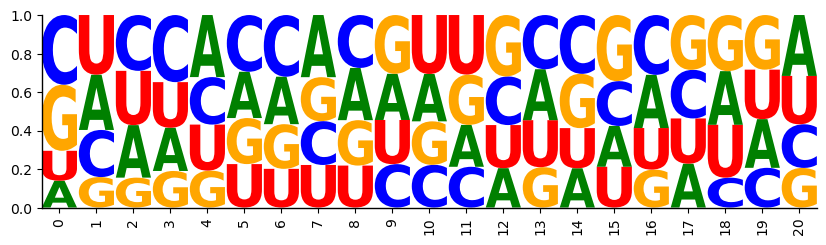

In [ ]:
# make logo figure

df = pd.DataFrame(motif)
df_normalized = df.div(df.sum(axis=1), axis=0)

# 로고 피규어 생성
logo = logomaker.Logo(df_normalized)

# 피규어 표시
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d', anchor=0)